# 0. Project introduction

For our Data 5 project, we use the dataset "Diabetes 130-US Hospitals for Years 1999-2008" from the UCI Machine Learning Repository. 

Each record in the dataset is a visit to the hospital by a patient with diabetes. 

The target/prediction variable is a label that encodes whether a patient was readmitted to the hospital in 30 days, after 30 days, or not at all. 

### Features description: 
Patient details, such as age group, race, medications prescribed during the visit, and diagnoses. 

### Target description: 
The target variable is 3 classes: `NO`, `<30`, and `>30`, indicating whether and when a patient returned to hospital after they were discharged. 
- `NO` indicates a patient did not return to hospital after discharge. 
- `<30` indicates a patient returned within 30 days of being discharged. 
- `>30` indicates a patient returned more than 30 days after discharge. 

# 1. Load dataset
https://archive.ics.uci.edu/dataset/296/diabetes+130-us+hospitals+for+years+1999-2008

In [2]:
# fetch dataset 
diabetes_130_us_hospitals_for_years_1999_2008 = fetch_ucirepo(id=296) 
  
# data (as pandas dataframes) 
X = diabetes_130_us_hospitals_for_years_1999_2008.data.features 
y = diabetes_130_us_hospitals_for_years_1999_2008.data.targets 

/Users/dora/anaconda3/lib/python3.12/site-packages/ucimlrepo/fetch.py:97: DtypeWarning: Columns (10) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(data_url)


readmitted
NO            54864
>30           35545
<30           11357
Name: count, dtype: int64


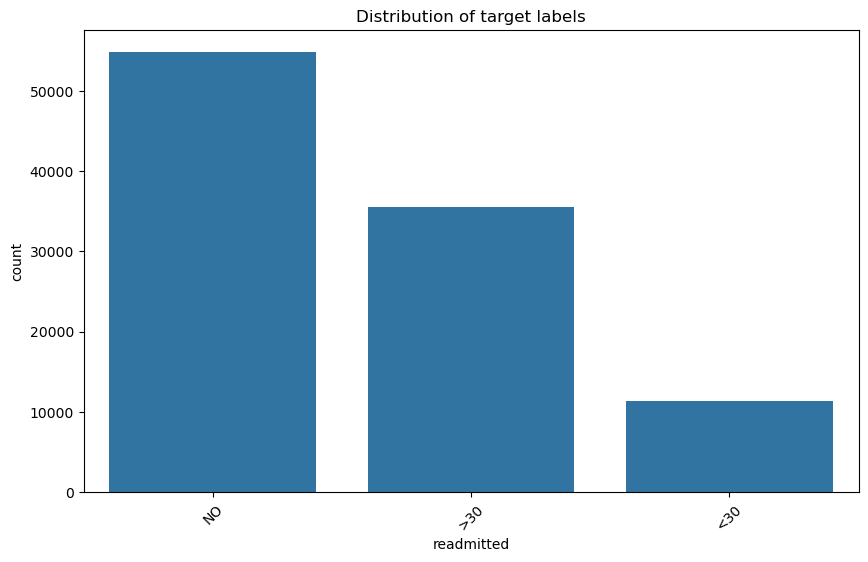

In [3]:
# Inspect target variable
print(y.value_counts())

plt.figure(figsize=(10, 6))
sns.countplot(x='readmitted', data=y)
plt.title('Distribution of target labels')
plt.xticks(rotation=45)
plt.show()

# 2. Remove records of deceased patients

We exclude patients who died from our experiments. Information on whether a patient died after the visit is given in the column `discharge_disposition_id`, which indicates the outcome of the hospital visit (e.g., discharged to home, left against medical advice, etc.). 

We removed records from patients who died during or after the hospital visit because this information "gives away" the target variable, i.e., that the patient did not return to the hospital (classification label `NO`).

We also removed records with `discharge_disposition_id` 12, indicating 'Still patient or expected to return for outpatient services', because this id would also "give away" the target variable. 


Below we include information on the values of `discharge_disposition_id` that were removed from the dataset.

- 11: 'Expired'
- 12: 'Still patient or expected to return for outpatient services'
- 13: 'Hospice / home'
- 14: 'Hospice / medical facility'
- 19: 'Expired at home. Medicaid only, hospice'
- 20: 'Expired in a medical facility. Medicaid only, hospice'
- 21: 'Expired, place unknown. Medicaid only, hospice'

In [4]:
# Remove records for patients who died

excluded_ids = [11, 12, 13, 14, 19, 20, 21]
X = X[~X['discharge_disposition_id'].isin(excluded_ids)]

In [5]:
# Remove corresponding target values
print(y.shape[0])
y = y.iloc[X.index]

# Remaining records
print(y.shape[0])

101766
99340


In [1]:
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from ucimlrepo import fetch_ucirepo 
import pandas as pd
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import seaborn as sns
RANDOM_STATE=0

# 3. Handle missing values

In this section, we explain the different strategies we use to handle missing values by column in our dataset. 

The columns `race`, `weight`, `payer_code`, `medical_specialty`, `diag1`, `diag2`, and `diag3`, `max_glu_serum`, and `A1Cresult` contain missing values. 

In [6]:
# Display columns that contain missing values
X.isna().sum()

race                         2234
gender                          0
age                             0
weight                      96215
admission_type_id               0
discharge_disposition_id        0
admission_source_id             0
time_in_hospital                0
payer_code                  39395
medical_specialty           48616
num_lab_procedures              0
num_procedures                  0
num_medications                 0
number_outpatient               0
number_emergency                0
number_inpatient                0
diag_1                         20
diag_2                        356
diag_3                       1419
number_diagnoses                0
max_glu_serum               94188
A1Cresult                   82506
metformin                       0
repaglinide                     0
nateglinide                     0
chlorpropamide                  0
glimepiride                     0
acetohexamide                   0
glipizide                       0
glyburide     

## `race` column - handle missing values

Below we show the values for the `race` column in our dataset.

race
Caucasian          74217
AfricanAmerican    18772
NaN                 2234
Hispanic            2017
Other               1472
Asian                628
Name: count, dtype: int64


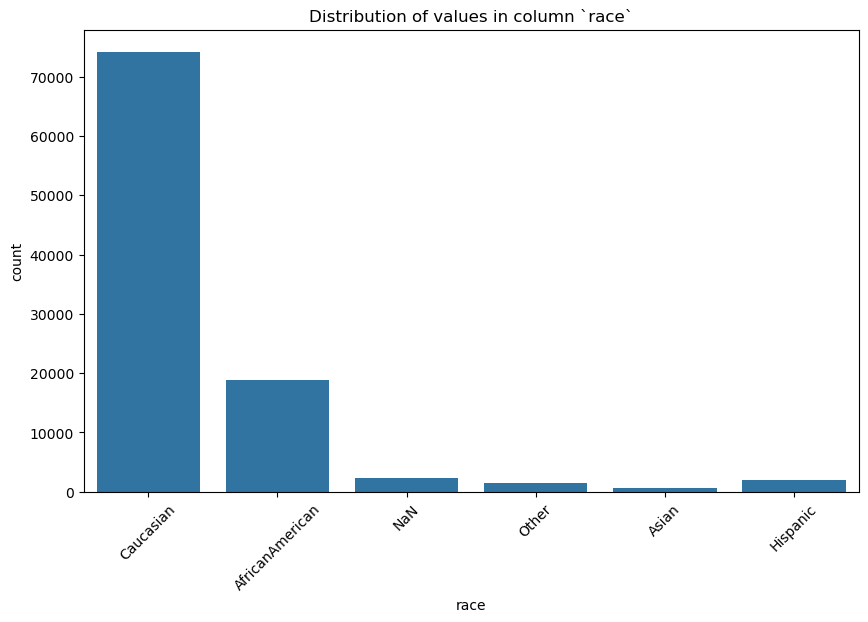

In [7]:
print(X.race.value_counts(dropna=False))

plt.figure(figsize=(10, 6))
data_to_plot = X.race.fillna("NaN").to_frame()
sns.countplot(x='race', data=data_to_plot)
plt.title('Distribution of values in column `race`')
plt.xticks(rotation=45)
plt.show()

There are 2234 missing values for `race` in this dataset. "Caucasian" is the most common race category by far, with over 74K records. 

**Strategy for missing values**: Impute most common value. 

Because the overwhelming majority of records in this dataset come from Caucasian patients, we assume that records with a missing value for `race` are "Caucasian".

## `weight` column - handle missing values

Below we show the values for the `weight` column in our dataset, which is a categorical variable.

weight
NaN          96215
[75-100)      1312
[50-75)        867
[100-125)      617
[125-150)      143
[25-50)         90
[0-25)          48
[150-175)       34
[175-200)       11
>200             3
Name: count, dtype: int64


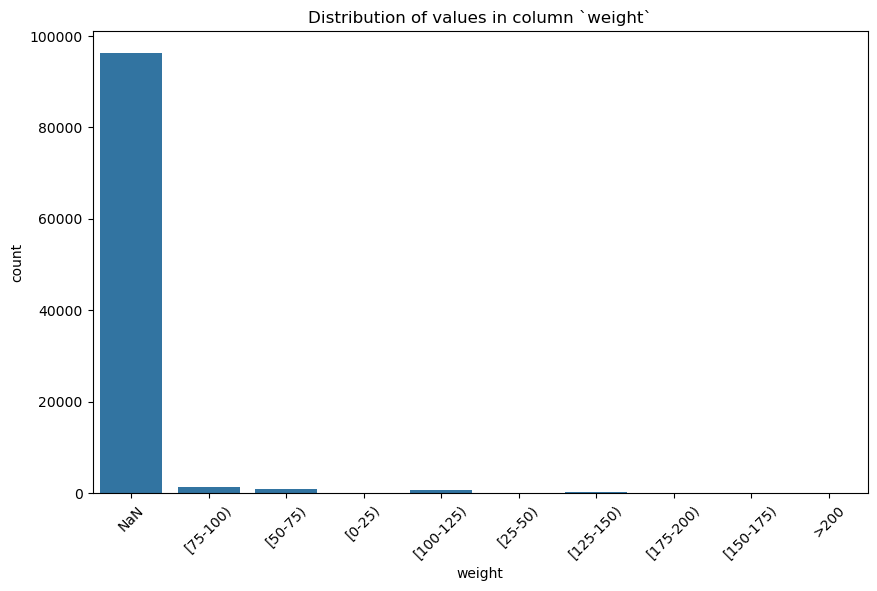

In [8]:
print(X.weight.value_counts(dropna=False))

plt.figure(figsize=(10, 6))
data_to_plot = X.weight.fillna("NaN").to_frame()
sns.countplot(x='weight', data=data_to_plot)
plt.title('Distribution of values in column `weight`')
plt.xticks(rotation=45)
plt.show()

The overwhelming majority have records (96K) do not have an associated value for "weight". We therefore assume this column will have limited predictive value for our multiclass problem. 

**Strategy for missing values**: Drop column `weight`.



## `payer_code` column - handle missing values

Below we show the values for the payer_code column in our dataset, which contains labels that indicate how the patient paid for the hospital visit (Medicare = "MC", for example)

payer_code
NaN    39395
MC     31333
HM      6195
SP      4941
BC      4601
MD      3473
CP      2466
UN      2411
CM      1880
OG      1011
PO       585
DM       545
CH       142
WC       135
OT        92
MP        79
SI        55
FR         1
Name: count, dtype: int64


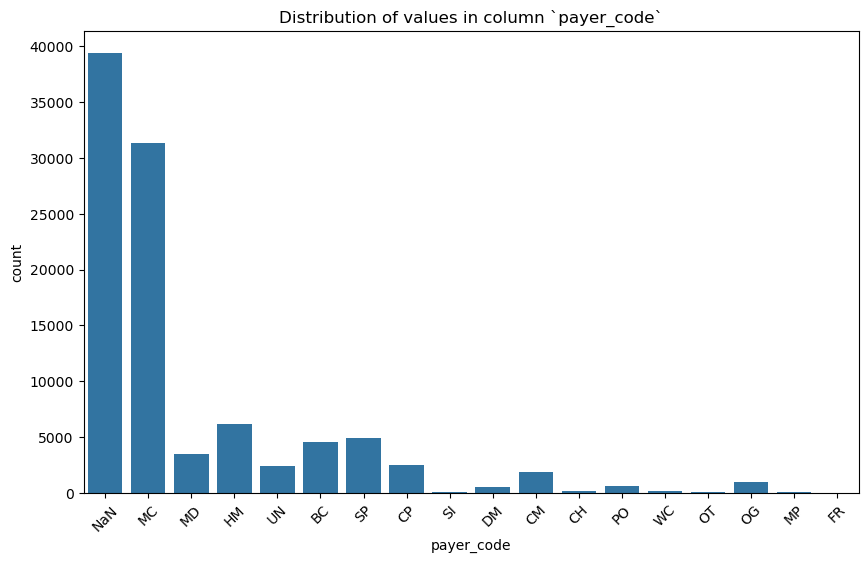

In [9]:
print(X.payer_code.value_counts(dropna=False))

plt.figure(figsize=(10, 6))
data_to_plot = X.payer_code.fillna("NaN").to_frame()
sns.countplot(x='payer_code', data=data_to_plot)
plt.title('Distribution of values in column `payer_code`')
plt.xticks(rotation=45)
plt.show()

We did not find any information on what a missing value for `payer_code` could mean - it may be a clerical error, but also indicate that a patient did not pay for their visit. 

We assumed `payer_code` might include information about the economic status of the patient, which could have predictive value for whether they were readmitted to hospital. Therefore, we assign missing values for `payer_code` "None"

**Strategy for missing values** : assign category "None".

## `medical_specialty` column - handle missing values

Below we show the values for the `medical_specialty` column in our dataset, which indicates the specialty of the treating physician during the hospital visit.
We do not include a graph for this section, because the medical_specialty column has 73 unique values. 

In [10]:
specialties = X.medical_specialty.value_counts(dropna=False)
pd.set_option('display.max_rows', len(specialties))
print(specialties)

pd.reset_option('display.max_rows')

medical_specialty
NaN                                     48616
InternalMedicine                        14235
Emergency/Trauma                         7419
Family/GeneralPractice                   7252
Cardiology                               5279
Surgery-General                          3059
Nephrology                               1539
Orthopedics                              1392
Orthopedics-Reconstructive               1230
Radiologist                              1121
Pulmonology                               854
Psychiatry                                852
Urology                                   682
ObstetricsandGynecology                   669
Surgery-Cardiovascular/Thoracic           642
Gastroenterology                          538
Surgery-Vascular                          525
Surgery-Neuro                             462
PhysicalMedicineandRehabilitation         391
Oncology                                  319
Pediatrics                                253
Neurology       

We assume the medical_specialty field for the treating physician may have some predictive value for whether the patient returned to the hospital after being discharged, as the presence of a specific specialty may indicate the severity of the patient's condition when arriving at the hospital.  

**Strategy for missing values**: assign category `none`.


## `diag1`, `diag2`, `diag3` column - handle missing values

The above columns indicate the primary, secondary, and tertiary diagnoses of the patient in a given record. Each value in these columns encodes a specific diagnosis using the first 3 digits of the ICD9 code. 

`diag_1` has 848 distinct values, `diag_2` has 923 distinct values, and `diag_3` has 954 distinct values.  

In [11]:
print(X.diag_1.value_counts())
print(X.diag_2.value_counts())
print(X.diag_3.value_counts())

diag_1
428    6663
414    6550
786    4015
410    3448
486    3383
       ... 
915       1
V60       1
57        1
314       1
V51       1
Name: count, Length: 715, dtype: int64
diag_2
276     6589
428     6459
250     6051
427     4892
401     3722
        ... 
46         1
V13        1
E850       1
800        1
927        1
Name: count, Length: 747, dtype: int64
diag_3
250    11466
401     8241
276     4953
428     4412
427     3785
       ...  
872        1
935        1
164        1
385        1
971        1
Name: count, Length: 786, dtype: int64


In [1]:
print(X.diag_1.value_counts().head(15))
print(X.diag_2.value_counts().head(15))
print(X.diag_3.value_counts().head(15))

NameError: name 'X' is not defined

Because a missing value indicates an absence of a diagnosis, and the list of possible diagnosis in these 3 columns overlap, we one-hot-encode these columns. We treat missing values as the absence of a diagnosis. 

We do not retain information about which column the diagnosis comes from (i.e. whether the diagnosis was the primary, secondary, or tertiary diagnosis). We throw out this information because retaining the column of origin would significantly increase the number of features in our final preprocessed dataset. 

**Strategy for missing values** : one hot encode diagnoses - absence of a diagnosis is "0", presence "1"

## `max_glu_serum` column - handle missing values

Below we show the values for the `max_glu_serum` column in our dataset, which indicates the result of the glucose serum test, if a patient underwent this test. The possible values are: >200, >300, normal, and none if not measured.

max_glu_serum
NaN     94188
Norm     2545
>200     1419
>300     1188
Name: count, dtype: int64


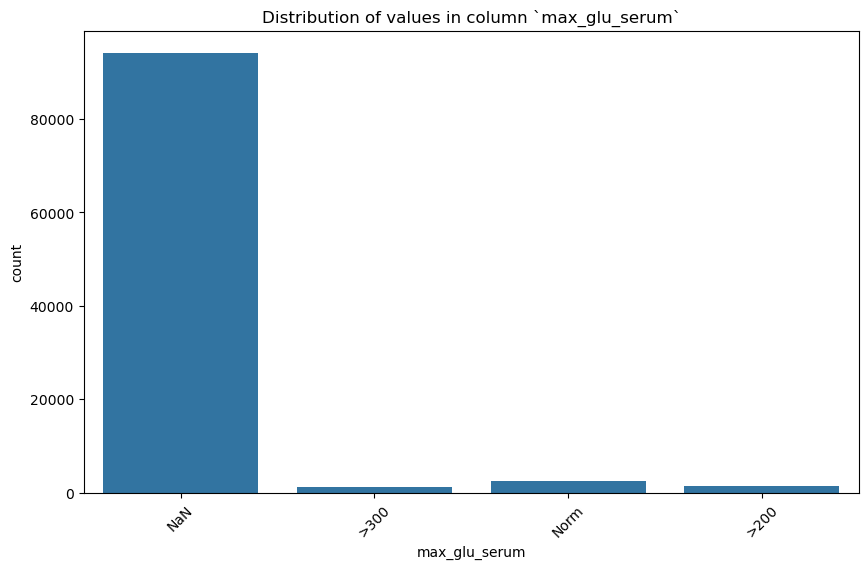

In [12]:
print(X.max_glu_serum.value_counts(dropna=False))


plt.figure(figsize=(10, 6))
data_to_plot = X.max_glu_serum.fillna("NaN").to_frame()
sns.countplot(x='max_glu_serum', data=data_to_plot)
plt.title('Distribution of values in column `max_glu_serum`')
plt.xticks(rotation=45)
plt.show()

We assume the absence of a glucose serum test result may have predictive value for whether the patient returned to the hospital, as no test result may indicate that the condition of the patient at the hospital did not necessitate a test/was not severe. 

**Strategy for missing values**: assign category `none`.

## `A1Cresult` column

Below we show the values for the A1Cresult column in our dataset, which indicates the result of the test for average blood glucose levels (HbA1c) in the last 2-3 months.

A1Cresult
NaN     82506
>8       8137
Norm     4922
>7       3775
Name: count, dtype: int64


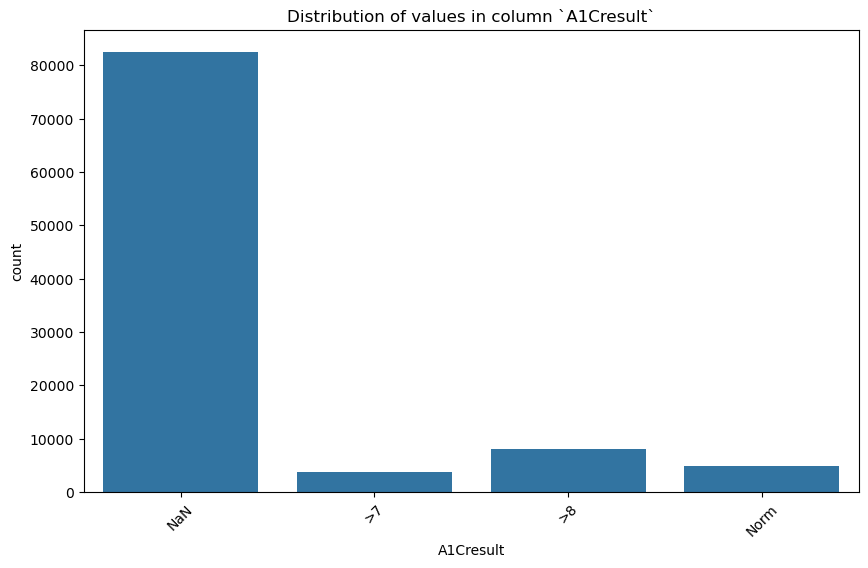

In [13]:
print(X.A1Cresult.value_counts(dropna=False))


plt.figure(figsize=(10, 6))
data_to_plot = X.A1Cresult.fillna("NaN").to_frame()
sns.countplot(x='A1Cresult', data=data_to_plot)
plt.title('Distribution of values in column `A1Cresult`')
plt.xticks(rotation=45)
plt.show()

We assume the absence of a HbA1c test may have predictive value for whether the patient returned to the hospital, as no test result may indicate that the condition of the patient at the hospital did not necessitate a test/was not severe.

**Strategy for missing values**: assign category `none`.

## Imputing missing values - summary


- `race` - impute most common

- `weight` - exclude this column - only a minority of patients were weighed

- `payer_code` - assign category "None"

- `medical_speciality` - assign category "None"

- `diag1`, `diag2`, `diag3` - one hot encode diagnoses - absence of a diagnosis is "0", presence "1"

Some of the values of ICD9 codes in the first, second, and third diagnosis columns overlap. We use one hot encoding to get a column that indicates the presence or absence of a diagnosis. For the purposes of our experiments, we assume the order of diagnosis (whether diagnosis was primary, secondary, or tertiary) doesn't matter.

- `max_glu_serum` - assign category "None"

- `A1Cresult` - assign category "None"

# 4. Define preprocessing pipline

In this section we provide an overview of the columns that need to be transformed into useable data, and how we will transform them.

## Columns to exclude:
- `weight` - most records do not include a weight measurment.

## Columns to convert to ordinal:
- `age` - The `age` column is a categorical variable - in this dataset, age is encoded as '[0-10)', '[10-20)', etc. We convert the `age` category values to ordinal values (0 for '[0-10)', 1 for '[10-20)', etc.)

## Columns to one-hot-encode: 
- `admission_type_id` - ID encoding how the patient was admitted to hospital (e.g. referral from primary care provider)
- `discharge_disposition_id` - ID encoding how the patient was discharged from the hospital (e.g. sent back home)
- `admission_source_id` - ID
- `gender` - male or female
- `race` - race category (caucasian, African American, etc.)
- `diag_1` - ID encoding the primary diagnosis
- `diag_2` - ID encoding the secondary diagnosis
- `diag_3` - ID encoding the tertiary diagnosis
- `medical_specialty` - ID encoding the speciality of the attending physician
- `payer_code` - label for the way in which the patient paid for the visit
- `max_glu_serum` - blood glucose serum result category
- `A1Cresult` - HbAC1 result category

## Numerical columns (scaled):
- `time_in_hospital` - number of days between admission and discharge
- `num_lab_procedures` - number of lab tests during visit
- `num_procedures` - number of non lab test procedures during visit
- `num_medications` - number of unique medications given during visit
- `number_outpatient` - number of outpatient visits the patient had during the year preceding the hospital visit
- `number_emergency` - number of emergency visits the patient had during the year preceding the hospital visit
- `number_inpatient` - number of inpatient visits the patient had during the year preceding the hospital visit
- `number_diagnoses` - number of patient diagnoses

## Convert boolean columns to 0/1 values:
- `change` - categorical value "change" or "no change" indicating if there was a change in diabetic medication was changed (dose or generic name).
- `diabetesMed` - categorical value "yes" or "no" indicating if a diabetic medication was prescribed 

In [14]:
# Drop weight column - most patients do not have a weight measurement

X=X.drop("weight", axis=1)

In [15]:
# Convert age categories to ordinal values
age_mapper = {
    '[0-10)': 0,
    '[10-20)': 1,
    '[20-30)': 2,
    '[30-40)': 3,
    '[40-50)': 4,
    '[50-60)': 5,
    '[60-70)': 6,
    '[70-80)': 7,
    '[80-90)': 8,
    '[90-100)': 9
}

X.age = X.age.replace(age_mapper)


/var/folders/jw/qsbcr78n1y1b26tl3v8sxkkc0000gn/T/ipykernel_61768/3665610338.py:15: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  X.age = X.age.replace(age_mapper)


In [16]:
# make a transformer to impute the most common value for race
most_common_columns=['race']
most_frequent_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('onehot', OneHotEncoder())])


In [17]:
# make a transformer to create "none" category for missing values in following columns
fill_missing_columns = ['payer_code', 'medical_specialty', 'max_glu_serum', 'A1Cresult']


none_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='constant', fill_value='none')),
    ('onehot', OneHotEncoder(handle_unknown='ignore'))])

In [18]:
# make transformer that collects all diagnoses and one hot encodes them
diagnosis_columns = ['diag_1', 'diag_2', 'diag_3']
def get_feature(input_feature, category): 
    return str(category)


diagnosis_transformer = OneHotEncoder(handle_unknown='ignore',  feature_name_combiner=get_feature)

In [19]:
# Define numeric columns that will be scaled
numeric_columns = ['time_in_hospital',
"num_lab_procedures",
"num_procedures",
"num_medications",
'number_outpatient',
'number_emergency',
'number_inpatient',
'number_diagnoses']

In [20]:
# Define categorical columns that will be one-hot-encoded
ohe_columns_rest=[
'admission_type_id',
'discharge_disposition_id',
'admission_source_id',
'gender',
'race'
]

In [21]:
# Combine the processing pipelines into one transformer
preprocessor = ColumnTransformer(
    transformers = [
        ('most_frequent', most_frequent_transformer, most_common_columns), # one hot encodes
        ('none', none_transformer, fill_missing_columns), # one hot encodes
        ('ohe', OneHotEncoder(handle_unknown='ignore'), ohe_columns_rest), # one hot encodes
        ('diagnoses', diagnosis_transformer, diagnosis_columns), #one hot encodes - special
        ('numerical_values', StandardScaler(), numeric_columns)
    ]
)

# 5. Split the data into a train (60%), validation (20%) and test set (20%)

In this section, we split the records into training, validation, and test sets. 
- Training set - we use this set to train models.
- Validation set - we use this set to evaluate and select the best model during our experiments.
- Test set - we only use this set at the end of our experiments, after model selection, to evaluate the performance of our selected model on unseen data.

In [22]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=RANDOM_STATE)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2, stratify=y_train, random_state=RANDOM_STATE)

# 6. Apply preprocessing pipeline

In this section, we apply the preprocessing pipeline we created in section 4 to the datasets created in section 5. 

## Train set

We fit the column transformer on the training set only. The column transformer then transforms the training data into useable form.

In [23]:
X_train_preprocessed = preprocessor.fit_transform(X_train)
X_train_preprocessed = pd.DataFrame(X_train_preprocessed.todense(), columns=preprocessor.get_feature_names_out())
X_train_preprocessed

,most_frequent__race_AfricanAmerican,most_frequent__race_Asian,most_frequent__race_Caucasian,most_frequent__race_Hispanic,most_frequent__race_Other,none__payer_code_BC,none__payer_code_CH,none__payer_code_CM,none__payer_code_CP,none__payer_code_DM,...,diagnoses__V86,diagnoses__nan,numerical_values__time_in_hospital,numerical_values__num_lab_procedures,numerical_values__num_procedures,numerical_values__num_medications,numerical_values__number_outpatient,numerical_values__number_emergency,numerical_values__number_inpatient,numerical_values__number_diagnoses
0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,-0.800245,-0.250665,1.573791,-0.614414,-0.295480,-0.204066,-0.504822,0.823550
1,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.884843,1.178358,-0.781626,0.506926,-0.295480,-0.204066,1.906044,0.823550
2,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,...,0.0,0.0,1.558878,0.974212,0.984937,-0.988194,-0.295480,-0.204066,-0.504822,0.823550
3,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,-0.463228,-1.526577,0.396083,1.379079,-0.295480,-0.204066,-0.504822,0.823550
4,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,-1.137263,-0.301701,-0.781626,-1.112788,0.513414,-0.204066,-0.504822,-1.237903
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
63572,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,2.232914,0.157627,-0.781626,-0.365228,-0.295480,-0.204066,-0.504822,-1.237903
63573,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,-0.463228,-0.403774,-0.781626,-0.489821,-0.295480,-0.204066,-0.504822,-0.207176
63574,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,2.569931,1.535613,0.984937,1.628266,-0.295480,-0.204066,-0.504822,0.823550
63575,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,-0.800245,1.331467,-0.781626,-0.116041,-0.295480,-0.204066,-0.504822,-0.722540


## Validation set

We transform the validation data with the fitted column transformer. The column transformer is not fitted on validation data. 

In [24]:
X_val_preprocessed = preprocessor.transform(X_val)
X_val_preprocessed = pd.DataFrame(X_val_preprocessed.todense(), columns=preprocessor.get_feature_names_out())
X_val_preprocessed

,most_frequent__race_AfricanAmerican,most_frequent__race_Asian,most_frequent__race_Caucasian,most_frequent__race_Hispanic,most_frequent__race_Other,none__payer_code_BC,none__payer_code_CH,none__payer_code_CM,none__payer_code_CP,none__payer_code_DM,...,diagnoses__V86,diagnoses__nan,numerical_values__time_in_hospital,numerical_values__num_lab_procedures,numerical_values__num_procedures,numerical_values__num_medications,numerical_values__number_outpatient,numerical_values__number_emergency,numerical_values__number_inpatient,numerical_values__number_diagnoses
0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,-0.463228,-0.505847,-0.781626,-0.988194,-0.295480,-0.204066,-0.504822,0.823550
1,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,-0.463228,0.004518,-0.781626,-0.863601,-0.295480,-0.204066,0.298800,-0.722540
2,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,-1.137263,-0.505847,-0.781626,-1.860348,2.131202,0.824058,-0.504822,-0.722540
3,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,-1.137263,-1.679687,-0.781626,-0.240634,-0.295480,-0.204066,-0.504822,-0.722540
4,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,-0.463228,0.412810,-0.781626,-0.240634,-0.295480,-0.204066,2.709666,-1.237903
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
15890,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,-0.463228,-0.148592,0.396083,0.382332,-0.295480,-0.204066,-0.504822,-2.268630
15891,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,-0.463228,1.280431,-0.192771,-0.365228,-0.295480,-0.204066,1.102422,0.823550
15892,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,-0.126210,-0.097555,-0.781626,-1.361975,-0.295480,-0.204066,-0.504822,-1.753267
15893,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,...,0.0,0.0,-0.463228,-0.709993,0.396083,-0.489821,-0.295480,-0.204066,-0.504822,-1.237903


## Test set

We transform the test data with the fitted column transformer. The column transformer is not fitted on test data. 

In [25]:
X_test_preprocessed = preprocessor.transform(X_test)
X_test_preprocessed= pd.DataFrame(X_test_preprocessed.todense(), columns=preprocessor.get_feature_names_out())

# 7. Verify that the train and test sets have no missing values

In this section we get the total number of NaN values per dataset. The datasets should no longer contain NaN values. 

In [26]:
print("Number of missing values:")
print("Train set:",X_train_preprocessed.isna().sum().sum())
print("Validation set:",X_val_preprocessed.isna().sum().sum())
print("Test set:",X_test_preprocessed.isna().sum().sum())

Number of missing values:
Train set: 0
Validation set: 0
Test set: 0


# 8. Save as CSV files

Lastly, we save our datasets to they can be used in the following notebooks. We also save a small subsample of the training data with a representative distribution of target labels. We use the subsample of training data to decrease model training times. 

## Train set

In [27]:
train_set = pd.concat([X_train_preprocessed, y_train.reset_index()], axis=1)
train_set.to_csv( "train_set.csv", index=False)

## Small sub-sample of the train set

We save a small sample of the training set to decrease model training time. We also use this dataset to select the optimal number of features used in training.

In [28]:
X_train_smaller, _, y_train_smaller, _ = train_test_split(
    X_train_preprocessed, 
    y_train, 
    train_size=0.1, 
    stratify=y_train, 
    random_state=RANDOM_STATE)

train_set_smaller = pd.concat([X_train_smaller.reset_index(), y_train_smaller.reset_index()], axis=1)
print(train_set_smaller.shape)
train_set_smaller.to_csv( "train_set_small.csv", index=False)

(6357, 2265)


## Validation set

In [29]:
validation_set =  pd.concat([X_val_preprocessed, y_val.reset_index()], axis=1)
validation_set.to_csv( "validation_set.csv",index=False )

## Test set

In [30]:
test_set = pd.concat([X_test_preprocessed, y_test.reset_index()], axis=1)
test_set.to_csv("test_set.csv", index=False)